# 03 - 统计回顾：最危险的公式

在 2007 年的著名文章中，霍华德·韦纳 (Howard Wainer) 针对非常危险的公式做了如下说明：

“有些公式如果你知道它们的话就很危险，而另一些公式如果你不知道它们就会很危险。第一类之所以可能会带来危险，是因为这些公式揭示了通往背后隐藏着的可怕危险。这其中最著名的是爱因斯坦相对论的经典公式：\\\ (E = MC^2\\)，因为它揭开了隐藏在普通物质中的巨大能量。... 另一方面，我对那些当我们不知道的时候会带来危险，而当我们明白了道理后反而没有问题的公式更感兴趣。当我们熟悉这些公式的时候，它们能让我们能够清楚地理解事物，但一旦不了解就会让我们处在无知的危险中。”

他所说的就是 Moivre 公式：

$
SE = \dfrac{\sigma}{\sqrt{n}}
$

其中 \\(SE\\) 是平均值的标准误差，\\(\sigma\\) 是标准偏差，\\(n\\) 是样本大小。听起来像一个勇敢而真实的人应该掌握的数学，所以让我们开始认真学习它。

要了解为什么不知道这个等式是非常危险的，让我们来看看一些教育数据。我已经收集了来自不同学校的 ENEM 分数（巴西标准化高中分数，类似于 SAT）的数据，为期 3 年。我还对数据进行了一些清理，只保留与我们相关的信息。原始数据可在[Inep网站]下载。(http://portal.inep.gov.br/web/guest/microdados#)下载。

如果我们看看表现最好的学校，就会注意到一些事情：这些学校的学生人数相当少。

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

In [3]:
df = pd.read_csv("./data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


换个角度看，我们只能把1%的顶尖学校分开来研究。 他们像什么？ 也许我们可以从最好的那里学到一些东西并在其他地方复制它。 果然，如果我们看看排名前 1% 的学校，我们会发现他们的学生平均更少。

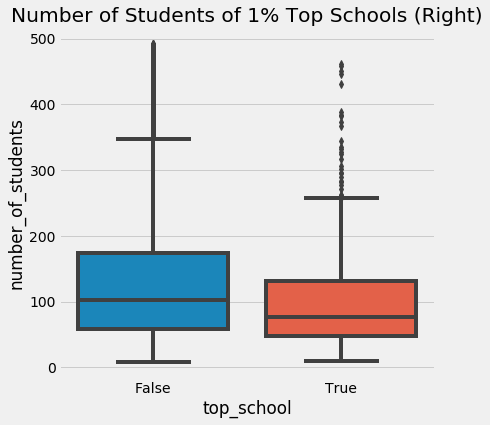

In [4]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

随之而来的一个自然结论是，小班教学会带来更高的学业成绩。 这具有直观的意义，因为我们相信每位教师的学生越少，教师就越可以专注于每个学生。 但这与 Moivre 方程有什么关系呢？ 为什么它是危险的？

好吧，一旦人们开始根据这些信息做出重要且代价高昂的决定，就会变得危险。 在他的文章中，霍华德继续说道：

“在 1990 年代，支持缩小学校规模变得流行起来。许多慈善组织和政府机构根据小学校的学生在考试成绩高的群体中人数过多的事实，资助了大学校的划分。”

人们忘记做的是还要看看排名垫底的 1% 的学校。 如果我们这样做，瞧！ 他们的学生也很少！

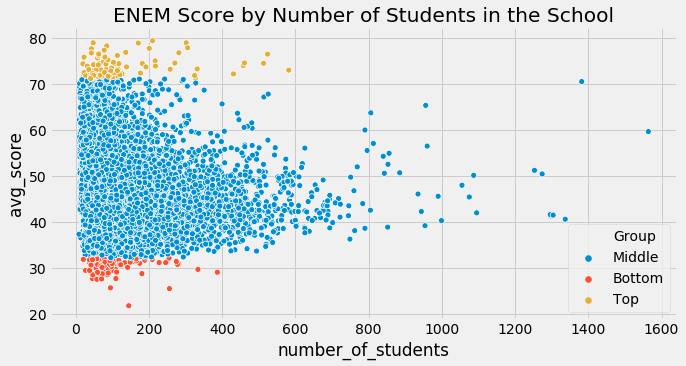

In [5]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

我们在上面看到的正是根据 Moivre 方程所预期的。随着学生人数的增加，平均分变得越来越精确。样本很少的学校可能会因为偶然而获得非常高和非常低的分数。大型学校不太可能发生这种情况。 Moivre 的方程谈到了一个关于信息和数据形式记录的现实的基本事实：它总是不精确的。那么问题就变得多么不精确。

统计学是处理这些不精确性的科学，因此它们不会让我们措手不及。正如塔勒布在他的书《被随机性愚弄》中所说：

> 概率不仅仅是计算骰子或更复杂的变体的几率；它是接受我们的知识缺乏确定性和发展处理我们的无知的方法。

量化我们的不确定性的一种方法是**我们估计的方差**。方差告诉我们观察值偏离了它们的中心值和最可能值的程度。正如 Moivre 方程所示，这种不确定性随着我们观察到的数据量的增加而缩小。这是有道理的，对吧？如果我们看到很多学生在学校表现出色，我们就会更有信心这确实是一所好学校。但是，如果我们看到一个只有 10 名学生并且其中 8 名学生表现良好的学校，我们需要多加怀疑。可能是因为偶然，这所学校有一些高于平均水平的学生。

我们上面看到的美丽的三角形图正是讲述了这个故事。它向我们展示了当样本量很小时，我们对学校表现的估计如何存在巨大差异。它还表明方差随着样本量的增加而缩小。这对于学校的平均分数是正确的，但对于我们拥有的任何汇总统计数据也是如此，包括我们经常想要估计的 ATE。

## 我们估计的标准误差

由于这只是对统计数据的回顾，我现在冒昧地讲得更快一些。如果您不熟悉分布、方差和标准误差，请继续阅读，但请记住，您可能需要一些额外的资源。我建议你谷歌任何麻省理工学院关于统计介绍的课程。他们通常都很好。

在上一节中，我们将平均处理效果 \\(E[Y_1-Y_0]\\) 估计为处理和未处理之间均值的差异 \\(E[Y|T=1]-E[Y |T=0]\\)。作为我们的激励示例，我们为在线课程找到了 \\(ATE\\)。我们还看到这是一个负面影响，即在线课程使学生的表现比面对面课程的学生差 5 分左右。现在，我们可以看看这种影响在统计上是否显着。

为此，我们需要估计 \\(SE\\)。我们已经有了 \\(n\\)，我们的样本大小。要获得标准偏差的估计值，我们可以执行以下操作

$
\hat{\sigma}^2=\frac{1}{N-1}\sum_{i=0}^N (x-\bar{x})^2
$

其中 \\(\bar{x}\\) 是 \\(x\\) 的平均值。对我们来说幸运的是，大多数编程软件已经实现了这一点。在 Pandas 中，我们可以使用方法 [std](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html)。

In [6]:
data = pd.read_csv("./data/online_classroom.csv")
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319106


## 置信区间

我们估计的标准误差是置信度的衡量标准。为了准确理解它的含义，我们需要进入充满争论的统计领域。对于统计学的一种观点，即频率学派的观点，我们会说我们拥有的数据只不过是真实数据生成过程的一种表现。这个过程是抽象的和理想的。它由不变但我们不知道的真实参数控制。在学生测试的背景下，如果我们可以运行多个实验并收集多个数据集，所有这些都将类似于真正的底层数据生成过程，但不会完全如此。这很像柏拉图在形式上的写作：

> 每一种$[$基本形式$]$都表现在各种各样的组合中，有行为，有物质，还有彼此，每一种似乎都有很多

为了更好地理解这一点，让我们假设我们有一个学生考试成绩的真实抽象分布。这是一个正态分布，真实平均值为 74，真实标准差为 2。从这个分布中，我们可以运行 10000 次实验。在每一个上，我们收集 500 个样本。有些实验数据的平均值会低于真实数据，有些会更高。如果我们将它们绘制在直方图中，我们可以看到实验的均值分布在真实均值附近。

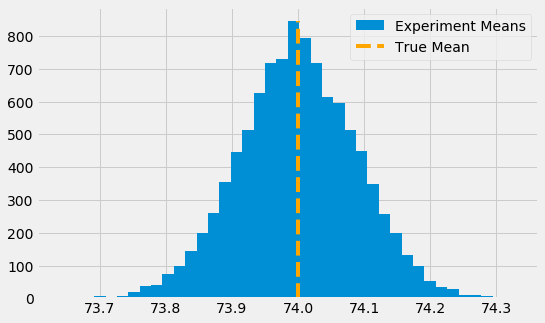

In [7]:
true_std = 2
true_mean = 74

n = 500
def run_experiment(): 
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();

请注意，我们在这里讨论的是均值的均值。因此，假如我们有机会进行一个实验，其中均值可能会略低于或高于真实均值。这就是说，我们永远无法确定实验的均值是否与真正的柏拉图式和理想均值相匹配。但是，**使用标准误差，我们可以创建一个区间，该区间将包含 95% 的时间的真实平均值**。

在现实生活中，我们无法用多个数据集模拟同一个实验。我们经常只有一个。但是我们可以利用上面的直觉来构建我们所说的**置信区间**。置信区间附带一个概率。最常见的是95%。这个概率告诉我们从不同的研究中建立的假设置信区间有多少包含真实的平均值。例如，从许多类似研究计算的 95% 置信区间将包含 95% 的时间的真实平均值。

为了计算置信区间，我们使用所谓的**中心极限定理**。该定理指出**实验均值是正态分布的**。从统计理论中，我们知道 95% 的正态分布的质量介于均值上下 2 个标准差之间。从技术上讲，1.96，但 2 已经足够接近了。

![normal_density](./data/img/stats-review/normal_dist.jpeg)

均值的标准误差用作我们对实验均值分布的估计。因此，如果我们将其乘以 2 并从我们的一个实验的平均值中加上和减去它，我们将为真实平均值构建一个 95% 的置信区间。